In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

# Load data

In [2]:
from src.load_data import get_epidemic_data, get_vaccine_data

### Epidemic data

In [3]:
df_epidemic = get_epidemic_data('Italy')
df_epidemic.head()

,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.0,0.0,0.0,0.0,0.0,0.0


### Vaccine data

In [4]:
df_vaccine = get_vaccine_data('Italy')
df_vaccine.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses
date,,
2020-12-29,0.02,0.0
2020-12-30,0.02,0.0
2020-12-31,0.07,0.0
2021-01-01,0.08,0.0
2021-01-02,0.15,0.0


In [5]:
media_ultimo_mese = int(np.mean(np.diff(np.sum(df_vaccine[-30:],axis=1))*60*10**6)/100)

print('vaccinazioni medie nell\'ultimo mese',media_ultimo_mese)

vaccinazioni medie nell'ultimo mese 221793


### Merging the two dataframes

In [6]:
df_merged = df_vaccine.join(df_epidemic,on=df_vaccine.index)

# the 3rd wave in Italy started approximately the 23th of February 2021, 
# with the increasing in the number of hospitalized people
df_merged = df_merged[df_merged.index >= '2021-04-06']

df_merged.head()

,% vaccinated with 1 dose,% vaccinated with 2 doses,Total cases,Active infected,Total deaths,Total recovered,Daily cases (avg 7 days),Daily deaths (avg 7 days)
date,,,,,,,,
2021-04-06,13.31,5.92,3686707.0,555705.0,111747.0,3019255.0,17956.4,409.7
2021-04-07,13.69,6.06,3700393.0,547837.0,112374.0,3040182.0,16499.1,432.6
2021-04-08,14.07,6.20,3717602.0,544330.0,112861.0,3060411.0,15788.4,430.6
2021-04-09,14.47,6.33,3736526.0,536361.0,113579.0,3086586.0,15360.9,464.4
2021-04-10,14.86,6.44,3754077.0,533085.0,113923.0,3107069.0,14832.9,459.9


# Fit of the epidemiological model

In [7]:
from src.epi_model import SIR2
from src.optimizer import fit_model 

In [8]:
inhabitants = 60*10**6

# true data vaccine
ydata_vacc = np.array(df_merged['% vaccinated with 2 doses'])*inhabitants/100
vacc_eff = 1
vacc_speed = 0.13

tmax = len(ydata_vacc)

# true data epidemic
ydata_cases = np.array(df_merged['Total cases']) + ydata_vacc
ydata_inf = np.array(df_merged['Active infected'])
ydata_rec = (np.array(df_merged['Total recovered'])+np.array(df_merged['Total deaths']))

ll = len(ydata_cases)

# optimization of the parameters of the SIR 2.0 model
minpar = fit_model(y_data = [ydata_cases,ydata_inf,ydata_rec],
                   inhabitants=inhabitants,
                   vacc_eff = vacc_eff,
                   vacc_speed = vacc_speed,
                   V0 = ydata_vacc[0],
                   which_error = 'perc',
                   decay=False)

Optimization terminated successfully.
         Current function value: 0.139411
         Iterations: 47
         Function evaluations: 90
Error on susceptible 0.0 %
Error on infected 0.3 %
Error on removed 0.1 %
The average error of the model is 0.1 %


In [9]:
beta = round(minpar[0],3)
gamma = round(minpar[1],3)
tau = round(minpar[2],1)

if tau >= 1000:
    tau=np.inf

print('Parametri ottimizzati: beta',beta,'gamma',gamma,'tau',tau)

Parametri ottimizzati: beta 0.034 gamma 0.039 tau inf


In [10]:
model_check = SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
              vacc_eff=vacc_eff,
              vacc_speed=vacc_speed,
              t0=0,  
              I0=ydata_inf[0],
              R0=ydata_rec[0],
              V0=ydata_vacc[0])


SN_ratio = model_check[1][ll]/inhabitants
Rt = round(beta/gamma*SN_ratio,2)
print('Parametro Rt per l\'Italia è pari a',Rt)

Parametro Rt per l'Italia è pari a 0.76


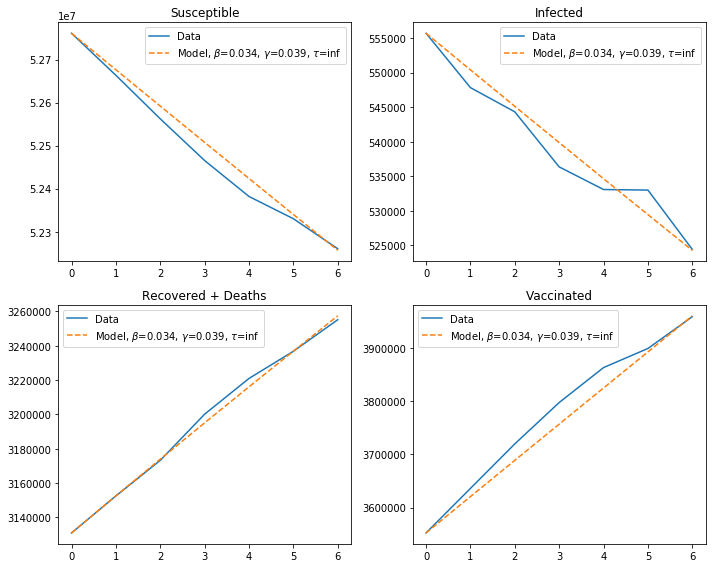

In [11]:
# check del modello, con curve di suscettibili, infetti e rimossi

plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(inhabitants-ydata_cases,label='Data')
plt.plot(model_check[1][0:ll],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.title('Susceptible')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ydata_inf,label='Data')
plt.plot(model_check[2][0:ll],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.title('Infected')
plt.legend()
plt.subplot(2,2,3)
plt.plot(ydata_rec,label='Data')
plt.plot(model_check[3][0:ll],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.title('Recovered + Deaths')
plt.legend()
plt.subplot(2,2,4)
plt.plot(ydata_vacc,label='Data')
plt.plot(model_check[4][0:ll],
         linestyle='--',label='Model, $\\beta$='+str(beta)+', $\gamma$='+str(gamma)+', $\\tau$='+str(tau))
plt.title('Vaccinated')
plt.legend()
plt.tight_layout()
plt.savefig('results/check_model_italy3rd.png',dpi=300)
plt.show()

### previsioni del modello epidemiologico

In [12]:
# model that accounts for lockdown (tau) and vaccination (vacc_speed)

pred_lockdown_vaccine=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = vacc_eff,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0]) 

pred_lockdown_vaccine_best=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = vacc_eff,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0],
                           vacc_custom = [len(ydata_cases),0.3]) 

pred_lockdown_vaccine_zero=SIR2(inhabitants,minpar[0],minpar[1],minpar[2],
                           vacc_eff = vacc_eff,
                           vacc_speed = vacc_speed,
                           t0=0,
                           I0=ydata_inf[0],
                           R0=ydata_rec[0],
                           V0=ydata_vacc[0],
                           vacc_custom = [len(ydata_cases),0]) 

# Risultati

In [15]:
# vaccinati con 1 dose e con 2 dosi
vaccinated_1dose = np.array(df_merged['% vaccinated with 1 dose'])
vaccinated_2dose = np.array(df_merged['% vaccinated with 2 doses'])

# incidenza settimanale ogni 100.000 abitanti
weekly_incidence = 7/(inhabitants/10**5)*np.array(df_merged['Daily cases (avg 7 days)'])

# decessi giornalieri per milione di abitanti
daily_deaths = 1/(inhabitants/10**6)*np.array(df_merged['Daily deaths (avg 7 days)'])

# dati sugli infetti attivi
ydata_inf_complete = np.array(df_merged['Active infected'])

xlab = ['May','Jun','Jul','Aug','Sep','Oct']

tmax = 150
xgrid = np.arange(0,len(pred_lockdown_vaccine[1]))

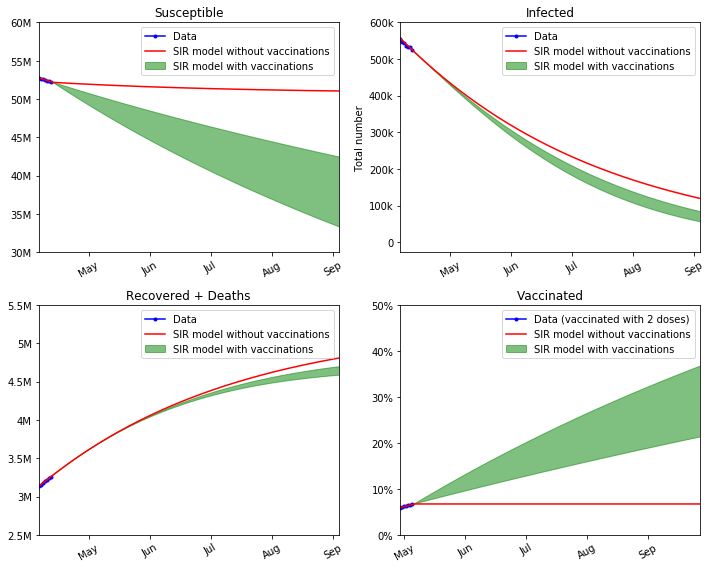

In [20]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(inhabitants-ydata_cases,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[1],pred_lockdown_vaccine_best[1],
                 label='SIR model with vaccinations',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[1],label='SIR model without vaccinations',color='red')
plt.xticks(np.arange(25,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.yticks(10**7*np.arange(0,6.1,0.5),['0','5M','10M','15M','20M','25M','30M','35M','40M','45M','50M','55M','60M'])
plt.ylim(30*10**6,60*10**6)
plt.title('Susceptible')
plt.legend()
plt.subplot(2,2,2)
plt.plot(ydata_inf_complete,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[2],pred_lockdown_vaccine_best[2],
                 label='SIR model with vaccinations',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[2],label='SIR model without vaccinations',color='red')
plt.title('Infected')
plt.yticks(10**5*np.arange(0,6.1,1),['0','100k','200k','300k','400k','500k','600k'])
plt.ylabel('Total number')
plt.xticks(np.arange(25,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.legend()
plt.subplot(2,2,3)
plt.plot(ydata_rec,label='Data',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine[3],pred_lockdown_vaccine_best[3],
                 label='SIR model with vaccinations',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[3],label='SIR model without vaccinations',color='red')
plt.xticks(np.arange(25,250,30.5),xlab,rotation=30)
plt.xlim(0,tmax)
plt.title('Recovered + Deaths')
plt.yticks(10**6*np.arange(0,6.1,0.5),['0','0.5M','1M','1.5M','2M','2.5M','3M','3.5M','4M','4.5M','5M','5.5M','6M'])
plt.ylim(2.5*10**6,5.5*10**6)
plt.legend()
plt.subplot(2,2,4)
plt.title('Vaccinated')
plt.plot(vaccinated_2dose,label='Data (vaccinated with 2 doses)',color='blue',marker='.')
plt.fill_between(xgrid,pred_lockdown_vaccine_best[4]/inhabitants*100,
                 pred_lockdown_vaccine[4]/inhabitants*100,
                 label='SIR model with vaccinations',alpha=0.5,color='green')
plt.plot(pred_lockdown_vaccine_zero[4]/inhabitants*100,label='SIR model without vaccinations',color='red')
plt.xticks(np.arange(2,250,30.5),xlab,rotation=30)
plt.yticks(np.arange(0,101,10),['0%','10%','20%','30%','40%','50%','60%','70%','80%','90%','100%'])
plt.ylim(0,50)
plt.xlim(0,tmax)
plt.legend()
plt.tight_layout()
plt.savefig('results/modello_italia_ondata3_vaccini_bande.png',dpi=300)
plt.show()